## Objective
The goal for this project is to simulate a simple model rocket in two diminsions. Eventuallly I might expand this to include:
- parachutes
- handle multiple stages
- have more complex aerodynamics
- simulate high power rocketry
- simulate going to orbit
- weather
- 3d
- and more...

## Our rocket
We'll be modeling our rocket based on the [Estes' Long Ranger](https://estesrockets.com/products/long-ranger) with a [C6-5 engine](https://estesrockets.com/products/c6-5-engines). Some specs for our rocket:
- Estes claims the max altitude is 1100 ft. (335 m)
- Length 65.8cm
- Weight 48g
- diameter 24mm

Engine specs
- total impulse 10 N-sec
- weight 24.1 g
- propellent weight 12.2 g
- time delay 5 seconds
    - this wont mater to us unless we start simulating realtime ground control
- max thrust 15.3 N
- Thrust duration 1.6 seconds
- [Thurst curve](https://www.thrustcurve.org/motors/Estes/C6/)

## Units
We will be using metric units: seconds (s), metres (m), newtons (N), and killograms (kg)

## Assumptions
- The earth is a perpect sphere
    - diameter of 12,756,000 meters
    - center of earth at corods x = 0, y = 6,378,000
    - air density at the surface is 1.225 kg/m3
    - gravity at the surface is 9.80665 m/s2 directly toward the center of the earth
- the coeffcieient of drag is 0.75
    - https://www.grc.nasa.gov/www/k-12/VirtualAero/BottleRocket/airplane/rktcodn.html
- Our rocket will take off from corods 0,0 at an angle 20 degress to the right of verticle

## Stop conditions
Our simulation will stop when one of the following occur:
- We hit the surface of the earth sometime after take off
    - e.g. do not count if we start on the surface of the earth
- 1 minute passes

In [107]:
# Setup
from cmath import pi
import json
from utils.thrust_curve import ThrustCurve
from utils.vector import *

from scipy.integrate import solve_ivp

import numpy as np

class Simulation:
    def __init__(self, config_path) -> None:
        f = open(config_path)
        config = json.load(f)

        self.log_telemetry = False
        self.we_have_liftoff = False

        earth_diameter = 12756000.00
        self.earth_diameter = earth_diameter
        self.earth_radius = earth_diameter / 2.0
        self.center_of_earth = Vector(0.0, -1.0 * earth_diameter / 2.0)
        self.gravity = config["gravity"]
        self.air_density = config["air_density"]

        self.target_orientation = np.deg2rad(5)
        self.total_weight = config["rocket"]["dry_weight"] + config["rocket"]["engine_weight"]
        self.prop_weight = config["rocket"]["propellent_weight"]
        self.diameter = config["rocket"]["diameter"]
        self.duration = config["rocket"]["duration"]
        self.thrust_curve = ThrustCurve(config["rocket"]["thrust_curve_rasp"])

    def thrust_force(self, t, P):
        Earth_rel_P = self.center_of_earth - P
        set_angle = np.deg2rad(180) + self.target_orientation
        angle_of_thrust = vector_angle(Earth_rel_P) - set_angle

        facing_cords = pol2cart(angle_of_thrust, 1)
        facing_vector = vector_hat(Vector(facing_cords[0], facing_cords[1]))

        thrust_mag = self.thrust_curve.get_thrust(t)

        return thrust_mag * facing_vector

    def drag_force(self, V):
        rho = self.air_density

        Cd = 0.75
        area = pi * (self.diameter/2)**2
        mag = rho * vector_mag(V)**2 * Cd * area
        direction = -1 * vector_hat(V)
        return mag * direction
    
    def calc_gravity(self, P):
        height_above_earth = vector_mag(P - self.center_of_earth) - self.earth_radius
        mag = self.gravity * np.square(self.earth_radius / (self.earth_radius + height_above_earth))
        direction = vector_hat(self.center_of_earth - P)
        return mag * direction

    def slope_func(self, t, values, args):
        x,y,vx,vy = values
        P = Vector(x,y)
        V = Vector(vx,vy)

        if t <= 0.0:
            mass = self.total_weight
        elif t >= self.duration:
            mass = self.total_weight - self.prop_weight
        else:
            mass = self.total_weight - (self.prop_weight * (t / self.duration))

        f_drag = self.drag_force(V)
        a_drag = f_drag / mass

        a_gravity = self.calc_gravity(P)

        f_thrust = self.thrust_force(t, P)
        a_thrust = f_thrust / mass

        A = a_drag + a_gravity + a_thrust

        # Dont move if we do not have positive thrust before liftoff
        # Sometimes the engine can take a moment to provide enough thrust
        if not self.we_have_liftoff:
            if A.y <= self.gravity:
                A = Vector(0.0, 0.0)
            else:
                self.we_have_liftoff = True

        return vx, vy, A.x, A.y

    def simulate(self, num=101):
        t_0 = 0.0
        t_max = 60.0

        solved = solve_ivp(
            self.slope_func,
            [t_0, t_max],
            [0.0, 0.0, 0.0, 0.0],
            dense_output=True,
            events=[collide_with_earth],
            args=[self]
            )
        
        y = solved.pop("y")
        t = solved.pop("t")
        
        t_final = t[-1]
        t_array = np.linspace(t_0, t_final, num)
        
        self.log_telemetry = True
        y_array = solved.sol(t_array)
        self.log_telemetry = False

        results = pd.DataFrame(y_array.T, index=t_array,
                        columns=['x','y','vx','vy'])
        
        return results
    


def collide_with_earth(t, state, sim):
    x, y, vx, vy = state
    height_above_earth = vector_mag(Vector(x, y) - sim.center_of_earth) - sim.earth_radius
    return -1 if sim.we_have_liftoff and height_above_earth <= 0.0 else 1

collide_with_earth.terminal = True



In [108]:
# run the sim!
sim = Simulation("./config/model-rocket.json")
results = sim.simulate()

0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.0
0.014
0.026
0.067
0.026
0.067
0.067
0.099
0.099
0.15
0.099
0.15
0.099
0.15
0.026
0.067
0.026
0.067
0.067
0.099
0.067
0.099
0.067
0.099
0.067
0.099
0.014
0.026
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.014
0.026
0.014
0.026
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.014
0.026
0.014
0.026
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.026
0.067
0.067
0.099
0.067
0.099
0.067
0.099
0.067
0.099
0.067
0.099
0.067
0.099
0.099
0.15
0.099
0.15
0.099
0.15
0.099
0.15
0.15
0.183
0.15
0.183
0.15
0.183
0.15
0.183
0.207
0.219
0.219
0.262
0.262
0.333
0.262
0.333
0.262
0.333
0.262
0.333
0.183
0.207
0.207
0.219
0.262
0.333
0.262
0.333
0.262

29.624969732352533
239.16342256627811
0.0
-6.880192091429649e-05


[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Position (m)')]

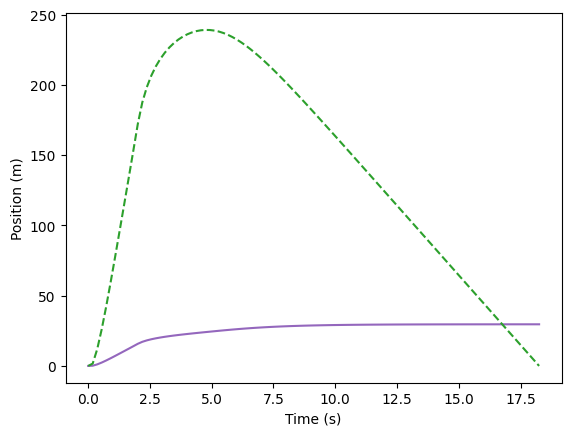

In [109]:
import matplotlib.pyplot as plt

results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

print(results.x.max())
print(results.y.max())
print(results.x.min())
print(results.y.min())

ax = plt.gca()
ax.set(xlabel='Time (s)',
         ylabel='Position (m)')

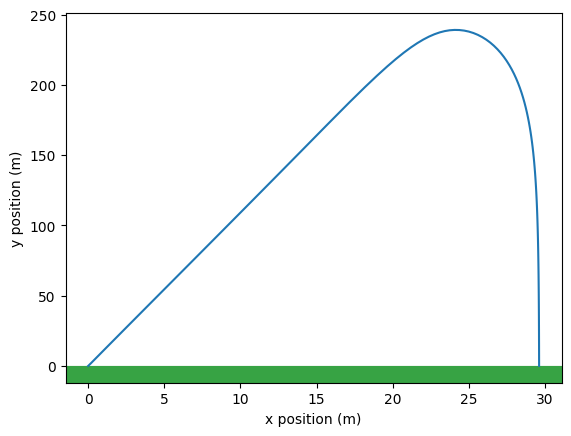

In [110]:
series = pd.Series(list(results.y), index=list(results.x))
series.index.name = 'index'

series.plot(label='trajectory')



ax = plt.gca()
ax.set(xlabel='x position (m)',
            ylabel='y position (m)')

pp2 = plt.Circle((sim.center_of_earth.x, sim.center_of_earth.y), sim.earth_diameter / 2)
pp2.set_facecolor('#37a344')
ax.add_patch(pp2)